# Finding optima of molecular simulations

Here we investigate the potential

$$
V\left(r_{i j}\right)=\left\{\begin{array}{l}{-\frac{e^{2}}{4 \pi \epsilon_{0} r_{i j}}+\alpha e^{-r_{i j} / \rho}+b\left(\frac{c}{r_{i j}}\right)^{12}} (\mathrm{+ -})\\ {+\frac{e^{2}}{4 \pi \epsilon_{0} r_{i j}}+b\left(\frac{c}{r_{i j}}\right)^{12}} (\mathrm{++ or --}) \end{array}\right.
$$

where the Coulomb force has constant:

$$ke^2 = e^2/4\pi\epsilon_0 = 1.44\; \mathrm{eV-nm}$$

with Pauli exclusion term:

$$\alpha = 1.09e3\;\mathrm{eV}$$

and a term to stabilize (or "regularize") the computation at small distances with:

$$b = 1.0\;\mathrm{eV}$$

$$c = 0.01\;\mathrm{nm}$$



The solution chosen is to use `numpy` arrays to fully vectorize the calculation. Granted, for small numbers of Na and Cl ions, this is a bit of overkill, but it's mostly for demonstration. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import itertools
import scipy.optimize

### Physical constants

In [2]:
ke2 = 197 / 137 # eV-nm   Coulomb force charge
alpha = 1.09e3  # eV      parameter of model
rho = 0.0321    # nm      parameter of model
b = 1.0         # eV      regular
c = 0.01        # nm

## Class to implement the potential calculation

This is fully vectorized!

- `init`: Inputs the positions of the Na and Cl ions as `ndarray`s with sizes `(N,3)`, with the second dimension representing 3-space. This will create a list of all of the combinations, and store their relative distances `rij` and potentials `Vij`. The positions are stored in "human readable" format in `positions`. 
- `Vij`: computes the vector of potentials `Vij_` from the positions (updated per iteration) and charges (static throughout) using the `combs` list of combinations (static throughout)
- `V`: computes the sum of `Vij()` (updated per iteration)
- `get_vals`: returns the flattened version of `positions`. 
- `set_vals`: inputs the flattened version of `positions` and reshapes correctly. 
- `__call__`: accepts the flattened positions, calls `set_vals` and then returns `V`. This is used by `scipi.optimize.minimize`. 

In [3]:

#Helpful solution to convert itertools combinations to numpy arrays here:
## https://stackoverflow.com/questions/33282369/convert-itertools-array-into-numpy-array
def cp(l):
    return np.fromiter(itertools.chain(*itertools.combinations(l,2)),dtype=int).reshape(-1,2)

class Cluster:
    def __init__(self, r_na, r_cl):
        '''
        Inputs the list of Na and Cl positions. Na has charge +1, Cl has -1.
        The array of ions itself does not change throughout the calculation, and
        neither do the charges. As such, we can just compute the combinations one time
        and refer to it throughout the calculation. 
        '''
        self.positions = np.concatenate( (r_na,r_cl))
        self.charges = np.concatenate( [np.ones(r_na.shape[0]), np.full(r_cl.shape[0], -1)] )
        self.combs = cp(np.arange(self.charges.size))
        self.chargeprods = self.charges[self.combs][:,0] * self.charges[self.combs][:,1]
        self.rij = np.linalg.norm(self.positions[self.combs][:,0] - self.positions[self.combs][:,1], axis=1)

    def Vij(self):
        '''Calculate a numpy vector of all of the potentials of the combinations'''
        self.Vij_ = np.zeros_like(self.rij)
        pos = self.chargeprods>0
        neg = ~pos
        self.Vij_[pos] = ke2 / self.rij[pos] + b*(c/self.rij[pos])**12
        self.Vij_[neg] =-ke2 / self.rij[neg] + alpha*np.exp(-self.rij[neg]/rho) + b*(c/self.rij[neg])**12
        return self.Vij_
    
    def V(self):
        '''Total potential, which is a sum of the Vij vector'''
        return np.sum(self.Vij())
    
    def get_vals(self):
        '''Positions interpreted as a flat shape'''
        return np.reshape(self.positions, -1)
        
    def set_vals(self, vals ):        
        '''Inputs flat shape of positions, used by __call__'''
        self.positions = vals.reshape(self.positions.shape)
        self.rij = np.linalg.norm(self.positions[self.combs][:,0] - self.positions[self.combs][:,1], axis=1)

    
    def __call__(self, vals):
        '''Function that  scipy.optimize.minimize will call'''
        self.set_vals(vals)
        return self.V()

## Run the simulation for a simple box

In [4]:
a = 0.2

r_na = np.array( [ [ 0, 0, 0 ], [ a, a, 0 ] ] )
r_cl = np.array( [ [ a, 0, 0 ], [ 0, a, 0 ] ] )

cluster = Cluster(r_na, r_cl)
vals_init = cluster.get_vals()
print('initial Na positions:\n', r_na)
print('initial Cl positions:\n', r_cl)
print('initial positions flattened shape:\n', vals_init )
print('initial V  :', cluster.V() )

initial Na positions:
 [[0.  0.  0. ]
 [0.2 0.2 0. ]]
initial Cl positions:
 [[0.2 0.  0. ]
 [0.  0.2 0. ]]
initial positions flattened shape:
 [0.  0.  0.  0.2 0.2 0.  0.2 0.  0.  0.  0.2 0. ]
initial V  : -10.008974314537344


## Run the optimization

Here, the optimizer will create a vector out of all of the molecular positions.
These can then be sent to our `Cluster` class via the `set_vals` method and interpreted correctly. 
At each iteration, the `Cluster` object will recalculate the potential.
The `minimize` function will adjust the values of the cluster positions
until the potential is minimized. 

In [5]:
res = scipy.optimize.minimize( fun=cluster, x0=vals_init, tol=1e-3, method="BFGS")
cluster.set_vals(res.x)  # For some reason, "minimize" is not updating the class at the last iteration
print ("Final optimized cluster positions")
print(cluster.positions)
print("Final potential:", res.fun)

Final optimized cluster positions
[[-0.02354035 -0.02413403 -0.00071742]
 [ 0.22348817  0.22408303  0.00070939]
 [ 0.22394609 -0.0234489   0.00753758]
 [-0.02399878  0.22339753 -0.00754628]]
Final potential: -13.069100259631682


## Make an interactive plot of the results

The blue dots are Cl, the red dots are Na. 

<IPython.core.display.Javascript object>


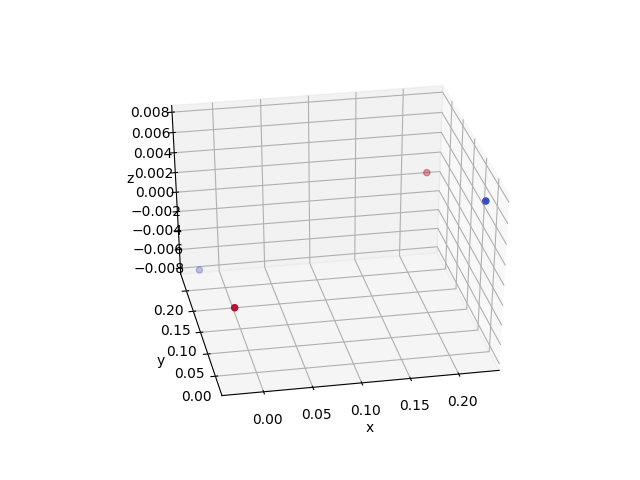

In [6]:
%matplotlib notebook

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

charges = cluster.charges
x,y,z = cluster.positions[:, 0], cluster.positions[:, 1], cluster.positions[:, 2]
ax.scatter( x,y,z, c=charges, cmap='coolwarm' )
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()